<a href="https://colab.research.google.com/github/ZiminPark/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an Environment

<p align="center"><img width="70%" src="https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator.png?raw=true" /></p>

- 위 그림에서 초록색과 파란색 블락들이 RecSim 환경에서 구현해야하는 부분들이다.
- 이번 노트에서는 각 블럭의 역할과 어떻게 얘네들이 조합되는지 살펴보자.
- 이 과정에서 end-to-end로 구현해볼 것이다.

# Overview

RecSim simulation의 한 step은 다음처럼 요약될 수 있다.


1.   document는 *D* documents를 추천시스템에 제공. 스텝마다 다를 수도 있고 시뮬레이션 기간동안 고정될 수도 있다. D는 a list of features 로 표현된다. fully observable 상황에서는 추천시스템이 유저의 state와 선택에 영향을 미치는 모든 feature를 볼 수 있다. 그러나 일반적으로 그럴 필요는 없을 것이다. <br>

2.   Agent는 *D* documents와 마지막 추천에 대한 반응을 관측할 수 있다. 그리고 다시 *k* documents를 유저에게 추천한다. 순서는 유저 선택이나 state에 영향을 줄 수도 있고 아닐 수도 있다. 당신의 goal에 따라 다르다.<br>

3. 유저는 추천된 documents목록을 보고 선택하거나 안 할 수도 있다. 이는 관측 유저의 반응과 latent space에 대한 반응을 만들어낸다. 보통 유저의 state가 fully 드러나지는 않는다.<br>

위의 그림을 자세히 보면 정보가 acyclic함을 알 수 잇다. 즉 RecSim은 dynamic Bayesian network (DBN)이다. Box는 conditional probability distributions을 나타낸다. 이제 간단한 시뮬레이션 문제를 정의하고 실행할 것이다.

#Simulation Scenario: Choc vs. Kale

다음 상황을 생각해보자. Corpus의 요소들이 얼마나 영양가있는가로 결정된다. 영양가있는 아이템은 `kale`로 후회스러운 아이템은 `chocalate`로 부르자. 후회스러운 documents는 유저들이 많이 반응하지만 장기적으로는 유저의 만족도를 하락시킨다. 반대로 영양가 있는 아이템은 반응은 적지만 장기적으로는 높은 만족감을 만든다. 우리는 document 특징을 [0,1] 사이의 연속적인 feature로 모델할 거고 Kaleness 척도로 부르자. 1이 영양가 높은 거고 0이 후회스러운 것이다.

유저의 latent state는 *satisfaction* 1차원 피쳐로 정의된다. "kaley"를 섭취하면 satisfaction이 증가하고 
"chocolate"을 섭취하면 감소한다. 유저가 아이템을 소비하면 engagement 척도를 emit한다. 이 수치는 유저의 만족도에 비례하고 kaleness에 반비례한다.

이제 우리의 목표는 장기적으로 유저의 engage가 높아지는 chocolatey and kaley 아이템 사이의 적절한 조합을 찾는 것이다.

다양한 요소들에 대한 함수 형태를 살펴보자.

In [ ]:
!pip install --upgrade --no-cache-dir recsim

In [2]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

#A Document Model

Document 클래스는 `recsim.document.AbstractDocument`를 상속받아 쓴다. 

base class를 상속받으면 `observation_space() `static method를 구현해야 한다. OpenAI gym의 `space` 타입으로 document observable features 형식을 반환한다. 그리고 realization of said space을 반환하는 `create_observation` 함수도 만들어야 한다.
각각의 document는 unique integer ID를 가져야한다.

우리의 경우 documents가 하나의 피쳐(kaleness value)만 갖는다.

In [4]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, kaleness):
    self.kaleness = kaleness
    # doc_id is an integer representing the unique ID of this document
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return np.array([self.kaleness])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return f"Document {self._doc_id} with kaleness {self.kaleness}."

이제 document sampler를 만들어 보자. 
`document.AbstractDocumentSampler`를 상속 받아 쓰고 `sample_document()`함수가 구현되어야 한다. 특정 분포에서 샘플한 `document`를 반환해야 한다.
우리의 경우 uniform distribution에서 추출할 것이다.

In [6]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._doc_count = 0

  def sample_document(self):
    doc_features = {}
    doc_features['doc_id'] = self._doc_count
    doc_features['kaleness'] = self._rng.random_sample()
    self._doc_count += 1
    return self._doc_ctor(**doc_features)

With this we can now simulate documents.

In [7]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(0.0, 1.0, (1,), float32) 
An example realization is:  [0.64589411]


RecSim에서는 직접 documents를 샘플하지 않고 시뮬레이터가 한다. 그래서 필요한 argument이다.

#A User Model

이제 유저 모델을 만들어 보자. 구성요소는 다음과 같다.
* a user state,
* a user sampler (a distribution over the starting state of users), 
* a user state transition model, and
* a user response.

튜토리얼에서 사용할 모델은 다음과 같다:
* 각각의 유저는 called net kale exposure($\text{nke}_t$)와 만족도($\text{sat}_t$)를 갖고 있다. 둘은 satisfaction이 unbounded되어 있음을 표현하기 위해 logistic function으로 엮여있다. 즉, $$\text{sat}_t = \sigma(\tau\cdot\text{nke}_t),$$ 이고 $\tau$는 유저 고유의 민감도 파라미터이다. Satisfaction과 net kale exposure는 bijectively 서로 얽혀있다. 그래서 state를 추적하기 위해서는 한 가지만 저장하면 된다.<br>

* slate $S$가 주어졌을 때 유저는 multinomial logit choice model을 기반으로 아이템을 선정한다. 이때 items' chocolateness를 피쳐로 쓴다. $p(\text{user chooses }d_i \text{ from slate }S) \sim e^{1-\mathrm{kaleness}(d_i)}$ 왜냐하면 초코리키한 걸 더 clicky하기 때문이다.

* 유저가 document를 선택하면 net kale exposure은 다음처럼 변한다. $$\text{nke}_{t+1} = \beta \cdot \text{nke}_t + 2(k_d - 1/2) + {\cal N}(0, \eta),$$ 
$\beta$는 유저 고유의 forgetting factor이고 $k_d$는 선택한 다큐의 kaleness, $\eta$는 노이즈 분포의 표준편차다.

* 마지막으로 유저가 선택한 콘텐츠를 $s_d$ 동안 사용했다. $s_d$는 $$s_d\sim\log{\cal N}(k_d\mu_k + (1-k_d)\mu_c, k_d\sigma_k + (1-k_d)\sigma_c),$$ 에서 만들어졌다. 즉, log-normal distribution이고 파라미터로는 pure kale response $(\mu_k, \sigma_k)$와 pure choc response $(\mu_c, \sigma_c)$ 사이를 linearly interpolating값으로 사용한다.

############## 여기까지
즉, 로그

i.e. a log-normal distribution with parameters linearly interpolating between the pure kale response $(\mu_k, \sigma_k)$ and the pure choc response $(\mu_c, \sigma_c)$.

Thus, a user state is defined by the tuple $(\text{sat}, \tau, \beta, \eta, \mu_k, \sigma_k, \mu_c, \sigma_c).$ The satisfaction variable is the only dynamic part of the state, whereas the other parameters define the user and are static. Technically, we are not required to keep these as part of the state as opposed to hardcoding them, however, it enables us to, say, sample users with different properties.



## User state and user sampler 
Similarly to documents, we begin by implementing a user state class, i.e. a class that acts as a container for all these parameters. Similarly to AbstractDocument, AbstractUserState requires us to implement an observation_space() and create_observations(). These are used to feed partial (or complete) information about the user's state to the agent at every iteration. 

We also maintain a time budget, which will cap the session length. In this scenario, the session length will be fixed to some constant, so it's not worth being explicit with our time budget modeling, but one can definitely consider this as part of the state and do more interesting thigs with it. 

Finally we will implement a score_document method, that maps a document to a non-negative real number. This significance of this will become clear shortly. 

In [ ]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, kale_mean, kale_stddev,
               net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
              ):
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.kale_mean = kale_mean
    self.kale_stddev = kale_stddev

    ## State variables
    ##############################
    self.net_kaleness_exposure = net_kaleness_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                           1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm(
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

Also similarly to our document model, we have need a starting state sampler, that sets the starting user state for every session. For this tutoral, we will just sample the starting $\text{nke}_0$ and keep all the static parameters the same, meaning that we essentially deal with the same user at different levels of satisfaction. One can, of course, extend this easily to generate also users with different parameters by randomizing the values. 

Observe that if $\eta = 0$, $\text{nke}$ would be bounded in the interval $\left[-\frac{1}{1-\beta}, \ldots, \frac{1}{1-\beta} \right]$ at all times, so as starting distribution we just sample uniformly from that range. Sampling code has to be implemented in sample_user(), as required by the base class.

In [ ]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'kale_mean': kale_mean,
                              'kale_stddev': kale_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_kaleness_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)


Let's try this out!

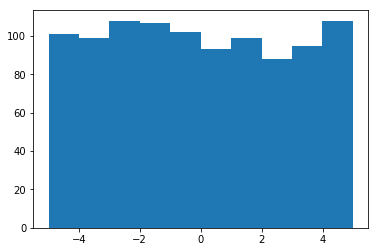

In [ ]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_kaleness_exposure)
_ = plt.hist(starting_nke)

## Response model

The next thing we want to check off our list is the user response class. RecSim will generate one response for every recommended item in the slate. The contents of the response are what the agent will see as document-specific feedback from the recommendation (the non-document specific feedback being generated in LTSUserState.create_observation).  

In [ ]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

##User model

Now that we have a way to generate users for our sessions, need to specify the actual user behavior. A RecSim user model (deriving from recsim.user.AbstractUserModel) is responsible for 
* maintaining user state, 
* evolving user state as a result of recommendations,
* generating a response to a slate of recommendations.

To this end, our user model is required by the base class to implement update_state() and simulate_response(), as well as is_terminal, which indicates when the end of the session occurs. This is facilitated by decreasing *self.time_budget* on every step.To make presentation clearer, we will define each function separately, and then assemble them into a class.



Our init is simple---we just pass the response_model constructor, user sampler and slate size down to the AbstractUserModel base class. Exploring other environments, the reader might notice that user model __init__ functions do offer a lot of flexibility for configuring the simulation. For now, however, we stick to the basics and hardcode things.

In [ ]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})

The simulate_response() method takes in a slate (list) of recommended (i.e., produced by the agent) LTSDocuments and must output a slate of user responses. The *k*-th response in the slate of responses corresponds to the *k*-th document in the recommendation slate. In this case, we pick one document to click on based on our choice model, and produce an engagement value. We will let the responses to the unclicked documents be vacuous, however, one might use them in more subtle ways (e.g., recording whether the user inspected that document, etc.).  

In [ ]:
def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  # Populate clicked item.
  self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and kale.
  engagement_loc = (doc.kaleness * self._user_state.choc_mean
                    + (1 - doc.kaleness) * self._user_state.kale_mean)
  engagement_loc *= self._user_state.satisfaction
  engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                      + ((1 - doc.kaleness)
                          * self._user_state.kale_stddev))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
  response.engagement = np.exp(log_engagement)

The update_state() method implements our state transition kernel. It consumes the recommended slate, as well as the actual choices (responses) to induce a state transition. The state is modified in-place, so the function does not return anything.

In [ ]:
def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      innovation = np.random.normal(scale=self._user_state.innovation_stddev)
      net_kaleness_exposure = (self._user_state.memory_discount
                                * self._user_state.net_kaleness_exposure
                                - 2.0 * (doc.kaleness - 0.5)
                                + innovation
                              )
      self._user_state.net_kaleness_exposure = net_kaleness_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                        * net_kaleness_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

Finally, the session expires when the time budget goes to 0.

In [ ]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0


We have all the components to instantiate a user model, so let's wrap them up in a class.

In [ ]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

Finally, we assemble all components into an Environment.

In [ ]:
 slate_size = 3
 num_candidates = 10
 ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)


## Recap
Before we conclude, let's take a second to recap everything we've done so far. The diagram below maps all the classes we've implemented/imported from RecSim to the functional diagram of RecSim.
![RecSim implementation](https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator_implemented.png?raw=true)



## Interacting with an agent

We now have a fully implemented environment in hand. In order to train/evaluate agents in this environment, we first need to specify a reward function. In RecSim, a reward function maps a set of responses to a real number. Suppose we want to maximize the engagement of the clicked documents.  

In [ ]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

Now, we simply use the OpenAI gym wrapper, which essentially provides a familiar step-based API.

In [ ]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [ ]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
doc_id 10 kaleness [0.79172504]
doc_id 11 kaleness [0.52889492]
doc_id 12 kaleness [0.56804456]
doc_id 13 kaleness [0.92559664]
doc_id 14 kaleness [0.07103606]
doc_id 15 kaleness [0.0871293]
doc_id 16 kaleness [0.0202184]
doc_id 17 kaleness [0.83261985]
doc_id 18 kaleness [0.77815675]
doc_id 19 kaleness [0.87001215]
Noisy user state observation
[0.41857747]
Observation 1
Available documents
doc_id 20 kaleness [0.97861834]
doc_id 21 kaleness [0.79915856]
doc_id 22 kaleness [0.46147936]
doc_id 23 kaleness [0.78052918]
doc_id 24 kaleness [0.11827443]
doc_id 25 kaleness [0.63992102]
doc_id 26 kaleness [0.14335329]
doc_id 27 kaleness [0.94466892]
doc_id 28 kaleness [0.52184832]
doc_id 29 kaleness [0.41466194]
User responses to documents in the slate
{'click': 0, 'engagement': 0.0}
{'click': 0, 'engagement': 0.0}
{'click': 1, 'engagement': 16.002030934389694}
Noisy user state observation
[0.47885928]
